In [9]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np, time, matplotlib.pyplot as plt, numpy.random as npr, pystan as ps, pickle
from pylab import plot, show, legend
from time import time
from scipy.stats import *
from tqdm import trange
from functions import *
import arviz as az
from collections import defaultdict
import json
from scipy.stats import norm
from scipy.stats import wasserstein_distance

In [10]:
alph_entries = [0.05, 0.25, 0.5]
alph_entry = 0.5
n_exp = len(alph_entries)
path = 'multiple_sims/'+str(alph_entry)

In [11]:
file = open(path+"/full_mcmc.pkl", "rb")
trace_full = pickle.load(file)
m = 10
n_mcmc, p = np.shape(trace_full['alpha'])
q = np.shape(trace_full['b'])[1]

In [12]:
n_mcmc, p, q

(500, 5, 5)

In [13]:
def cred_ints_dc(quantiles, path):
    n_q = len(quantiles)
    quant_dc = {}
    quant_dc['alpha'] = np.zeros((n_q, p))
    quant_dc['b'] = np.zeros((n_q, q))
    quant_dc['c'] = np.zeros(n_q)    
    for i in range(m):
        file = open(path+"/mcmc_wb_chunk"+str(i+1)+".pkl", "rb")
        trace = pickle.load(file)
        for var_name in ['alpha','b','c']:
            quant_dc[var_name] += np.percentile(trace[var_name],axis=0,q=quantiles)/m
            
    return quant_dc

def cred_ints_full(quantiles, path):
    n_q = len(quantiles)
    quant_full = {}
    quant_full['alpha'] = np.zeros((n_q, p))
    quant_full['b'] = np.zeros((n_q, q))
    quant_full['c'] = np.zeros(n_q)
    file = open(path+"/full_mcmc.pkl", "rb")
    trace = pickle.load(file)
    for var_name in ['alpha', 'b', 'c']:
        quant_full[var_name] = np.percentile(trace[var_name],axis=0,q=quantiles)
        
    return quant_full

def cred_ints_laplace(quantiles):
    n_q = len(quantiles)
    with open("laplace.json") as f:
        laplace = json.load(f)
    mode, hessian = np.array(laplace['mode']), np.array(laplace['hessian'])
    var_names = laplace['var_names']
    stds = np.sqrt(np.diag(np.linalg.inv(-hessian)))
    res = np.zeros((p+q+1, n_q))
    i = 0
    for mode, std in zip(modes, stds):
        res[i,:] = norm.ppf(np.array(quantiles) / 100, loc=mode, scale=std)
        i += 1
    return (res[:p], res[p], res[(p+1):])

In [14]:
n_exp = len(alph_entries)
results = {}
quantiles = np.arange(0.1, 1.0, 0.1)
for alph_entry in alph_entries:
    path = 'multiple_sims/'+str(alph_entry)
    alph_str = str(alph_entry)
    results[alph_str] = {}
    results[alph_str]['full'] = cred_ints_full(quantiles, path)
    results[alph_str]['dc'] =  cred_ints_dc(quantiles, path)
    # calculate the errors
    error = {}
    for var_name in ['alpha', 'b', 'c']:
        error[var_name] = np.absolute(results[alph_str]['dc'][var_name] - results[alph_str]['full'][var_name])
    results[alph_str]['error'] = error
        

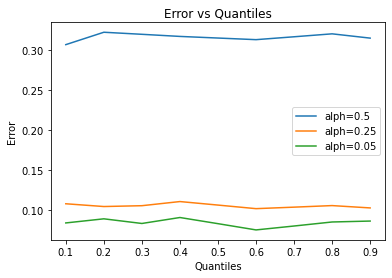

In [22]:
# Plotting the line chart
plt.plot(quantiles, np.sum(results['0.5']['error']['alpha'], axis =1), label='alph=0.5')
plt.plot(quantiles, np.sum(results['0.25']['error']['alpha'], axis =1), label='alph=0.25')
plt.plot(quantiles, np.sum(results['0.05']['error']['alpha'], axis =1), label='alph=0.05')

# Adding labels and title
plt.xlabel('Quantiles')
plt.ylabel('Error')
plt.title('Error vs Quantiles')

# Adding a legend
plt.legend()

# Displaying the chart
plt.show()